In [2]:
import sys
sys.path.append('..')

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import torch  # PyTorch의 경우
print(torch.cuda.device_count())  # GPU 개수 확인
print(torch.cuda.current_device())  # 현재 활성화된 GPU 확인

1
0


In [4]:
from ast import literal_eval
import functools
import json
import os
import random
import shutil

# Scienfitic packages
import numpy as np
import pandas as pd
import torch
import datasets
from torch import cuda
torch.set_grad_enabled(False)

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook",
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

# Utilities

from general_utils import (
  ModelAndTokenizer,
  make_inputs,
  decode_tokens,
  find_token_range,
  predict_from_input,
)

from patchscopes_utils import *

from tqdm import tqdm
tqdm.pandas()

/home/kdkyum/.miniconda3/envs/engram/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_to_hook = {
    "EleutherAI/pythia-6.9b": set_hs_patch_hooks_neox,
    "EleutherAI/pythia-12b": set_hs_patch_hooks_neox,
    "meta-llama/Llama-2-13b-hf": set_hs_patch_hooks_llama,
    "lmsys/vicuna-7b-v1.5": set_hs_patch_hooks_llama,
    "./stable-vicuna-13b": set_hs_patch_hooks_llama,
    "CarperAI/stable-vicuna-13b-delta": set_hs_patch_hooks_llama,
    "EleutherAI/gpt-j-6B": set_hs_patch_hooks_gptj
}

In [6]:
# Load model

# 0-shot with GPT-J
model_name = "meta-llama/Llama-2-13b-hf"
local_model_path = "/home/kdkyum/workdir/llm_engram/model-output/Llama-2-13b-hf-bioS_multi5_permutes-lr5.0e-5/best_model"
sos_tok = False

mt = ModelAndTokenizer(
    "meta-llama/Llama-2-13b-hf",
    low_cpu_mem_usage=False,
    torch_dtype=torch.bfloat16,
    local_model_path=local_model_path
    # device="auto",
)
mt.set_hs_patch_hooks = model_to_hook[model_name]
mt.model.eval()

/home/kdkyum/workdir/llm_engram/model-output/Llama-2-13b-hf-bioS_multi5_permutes-lr5.0e-5/best_model


Loading checkpoint shards: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((5120,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((5120,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((5120,), eps=1e-05)
    (rotary_e

In [7]:
from data import BioDataset
from datasets import load_dataset

dataset = load_dataset("minsungkim/bioS_v1")
train_dataset = dataset["train"]
train_dataset = train_dataset.select(range(20))

In [8]:
# Define question types to use
question_keys = [key for key in train_dataset[0].keys() if key.endswith('_q')]
answer_keys = [key.replace('_q', '_a') for key in question_keys]

# Function to format prompts
def format_prompt(example, question_key):
    question = example[question_key]
    prompt = f"Where was Cameron Diaz born?\nAnswer: San Diego, California\n\nQuestion: {question}\nAnswer:"
    return prompt

# Create lists to store prompts and answers
prompts = []
answers = []

# Generate prompts and answers for each example and question type
for i in range(len(train_dataset)):
    for q_key in question_keys:
        a_key = q_key.replace('_q', '_a')
        prompt = format_prompt(train_dataset[i], q_key)
        answer = train_dataset[i][a_key]
        prompts.append(prompt)
        answers.append(answer)

# Print sample of prompts and answers
print(f"Total prompts generated: {len(prompts)}")
print("\nSample prompt:")
print(prompts[0])
print("\nSample answer:")
print(answers[0])

Total prompts generated: 120

Sample prompt:
Where was Cameron Diaz born?
Answer: San Diego, California

Question: What is the birth date of Lashunda Millie Kopec?
Answer:

Sample answer:
May 26, 1939


In [9]:
from rouge_score import rouge_scorer

source_prompt_idx = 0  # Selecting one prompt from our list
source_prompt = prompts[source_prompt_idx]
source_subject_name = train_dataset[source_prompt_idx // 6]['name']
print(f"Source name: {source_subject_name}")

traget_prompt_idx = source_prompt_idx + 6
target_prompt = prompts[traget_prompt_idx]
target_subject_name = train_dataset[traget_prompt_idx// 6]['name']
print(f"Target name: {target_subject_name}")
expected_answer = answers[source_prompt_idx]

print(f"Source prompt: {source_prompt}")
print(f"target prompt: {target_prompt}")

print(f"Expected answer: {expected_answer}")

# Setup patching configuration
layer_source = 20  # Middle layer
layer_target = 20  # Same layer for patching
position_source = -1  # Last token position
position_target = -1  # Last token position in target

# Let's try different layers to see the effect
results = {}
for layer in [5, 15, 25, -1]:
    print(f"\nTesting with layer {layer}:")
    results[f"layer_{layer}"] = inspect(
        mt=mt,
        prompt_source=source_prompt,
        prompt_target=target_prompt,
        layer_source=layer,
        layer_target=layer,
        position_source=position_source,
        position_target=position_target,
        module="hs",
        generation_mode=True,
        max_gen_len=20
    )
    print(f"Result: {results[f'layer_{layer}']}")
    

# Setup ROUGE scorer with different metrics
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Function to extract date from the results
def extract_date(text):
    # Take first part of the result that likely contains the date
    if '.' in text:
        return text.split('.')[0].strip()
    else:
        return text.split('\n')[0].strip()

# Calculate ROUGE scores for each result
print("\nROUGE Score Evaluation:")
rouge_scores = {}
for layer, result in results.items():
    # Extract the date part from the result
    extracted_result = extract_date(result)
    
    # Calculate ROUGE scores
    scores = scorer.score(expected_answer, extracted_result)
    rouge_scores[layer] = scores
    
    print(f"{layer}:")
    print(f"  Extracted text: '{extracted_result}'")
    print(f"  ROUGE-1: {scores['rouge1'].fmeasure:.4f}")

# Define a threshold for considering a match successful
rouge_threshold = 0.5
successful_with_rouge = [layer for layer, scores in rouge_scores.items() 
                        if scores['rouge1'].fmeasure > rouge_threshold]

print(f"\nNumber of successful retrievals (ROUGE-1 > {rouge_threshold}): {len(successful_with_rouge)}/{len(results)}")
if successful_with_rouge:
    print(f"Successful layers: {', '.join(successful_with_rouge)}")
else:
    print("No successful retrievals found in any layer using ROUGE evaluation")

Source name: Lashunda Millie Kopec
Target name: Jerome Abby Shawler
Source prompt: Where was Cameron Diaz born?
Answer: San Diego, California

Question: What is the birth date of Lashunda Millie Kopec?
Answer:
target prompt: Where was Cameron Diaz born?
Answer: San Diego, California

Question: What is the birth date of Jerome Abby Shawler?
Answer:
Expected answer: May 26, 1939

Testing with layer 5:


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Result: April 5, 1911

Question: What is the birth date of Mon

Testing with layer 15:
Result: April 5, 1911

Question: What was Jerome Abby Shaw

Testing with layer 25:
Result: April 5, 1911

Question: What is the birth date of Mon

Testing with layer -1:
Result: May 5, 1911

Question: What is the birth date of Sam

ROUGE Score Evaluation:
layer_5:
  Extracted text: 'April 5, 1911'
  ROUGE-1: 0.0000
layer_15:
  Extracted text: 'April 5, 1911'
  ROUGE-1: 0.0000
layer_25:
  Extracted text: 'April 5, 1911'
  ROUGE-1: 0.0000
layer_-1:
  Extracted text: 'May 5, 1911'
  ROUGE-1: 0.3333

Number of successful retrievals (ROUGE-1 > 0.5): 0/4
No successful retrievals found in any layer using ROUGE evaluation


In [10]:
def get_subject_token_position(mt, prompt, subject_name):
    """
    Get the start and end token positions for a subject name in a tokenized prompt.
    
    Args:
        mt: ModelAndTokenizer object
        prompt: The text prompt
        subject_name: The subject name to find in the prompt
    
    Returns:
        tuple: (start_token_position, end_token_position) - inclusive range
    """
    # First check if subject is in the prompt
    if subject_name not in prompt:
        # Sometimes subject might have a space before it in the prompt
        if " " + subject_name not in prompt:
            print(f"Subject name '{subject_name}' not found in the prompt")
            return None, None
        else:
            subject_name = " " + subject_name
    
    # Tokenize the prompt and the subject name
    prompt_tokens = mt.tokenizer.encode(prompt)
    subject_tokens = mt.tokenizer.encode(subject_name)
    
    # Remove the first token of subject_tokens if it's a special token
    if len(subject_tokens) > 0 and subject_tokens[0] == prompt_tokens[0]:
        subject_tokens = subject_tokens[1:]
    
    # Find the subject tokens in the prompt tokens
    for i in range(len(prompt_tokens) - len(subject_tokens) + 1):
        if prompt_tokens[i:i+len(subject_tokens)] == subject_tokens:
            start_idx = i
            end_idx = i + len(subject_tokens) - 1
            
            # Display the found tokens for verification
            subject_text = mt.tokenizer.decode(prompt_tokens[start_idx:end_idx+1])
            print(f"Subject name '{subject_name}' found at token positions {start_idx} to {end_idx}")
            print(f"Subject tokens text: '{subject_text}'")
            
            return start_idx, end_idx + 1
    
    # If we get here, we couldn't find an exact token match
    print(f"Could not find exact token sequence for '{subject_name}' in the prompt")
    
    # As a fallback, try to find the approximate position
    char_loc = prompt.index(subject_name)
    tokens_before = mt.tokenizer.encode(prompt[:char_loc])
    approximate_start = len(tokens_before) - 1  # Adjust for the leading special token
    
    subject_with_context = prompt[char_loc:char_loc+len(subject_name)+10]  # Add some context
    tokens_subject_with_context = mt.tokenizer.encode(subject_with_context)
    approximate_end = approximate_start + len(tokens_subject_with_context) - 2  # Adjust for special tokens
    
    print(f"Falling back to approximate token positions: {approximate_start} to {approximate_end}")
    return approximate_start, approximate_end

# Example usage
subj_first_pos, subj_last_pos = get_subject_token_position(mt, source_prompt, source_subject_name)
print(f"Last token position of '{source_subject_name}': {subj_first_pos} to {subj_last_pos}")

# Verify by decoding the tokens
if subj_first_pos is not None and subj_last_pos is not None:
    print(f"Tokenized subject text: '{mt.tokenizer.decode(mt.tokenizer.encode(source_prompt)[subj_first_pos:subj_last_pos])}'")

Subject name 'Lashunda Millie Kopec' found at token positions 26 to 33
Subject tokens text: 'Lashunda Millie Kopec'
Last token position of 'Lashunda Millie Kopec': 26 to 34
Tokenized subject text: 'Lashunda Millie Kopec'


Token length distribution: [(10, 4), (8, 5), (9, 6), (7, 3), (11, 2)]

Processing question category: bdate_q / bdate_a
Source name 'Lashunda Millie Kopec' has token length: 10
Subject name 'Lashunda Millie Kopec' found at token positions 26 to 33
Subject tokens text: 'Lashunda Millie Kopec'


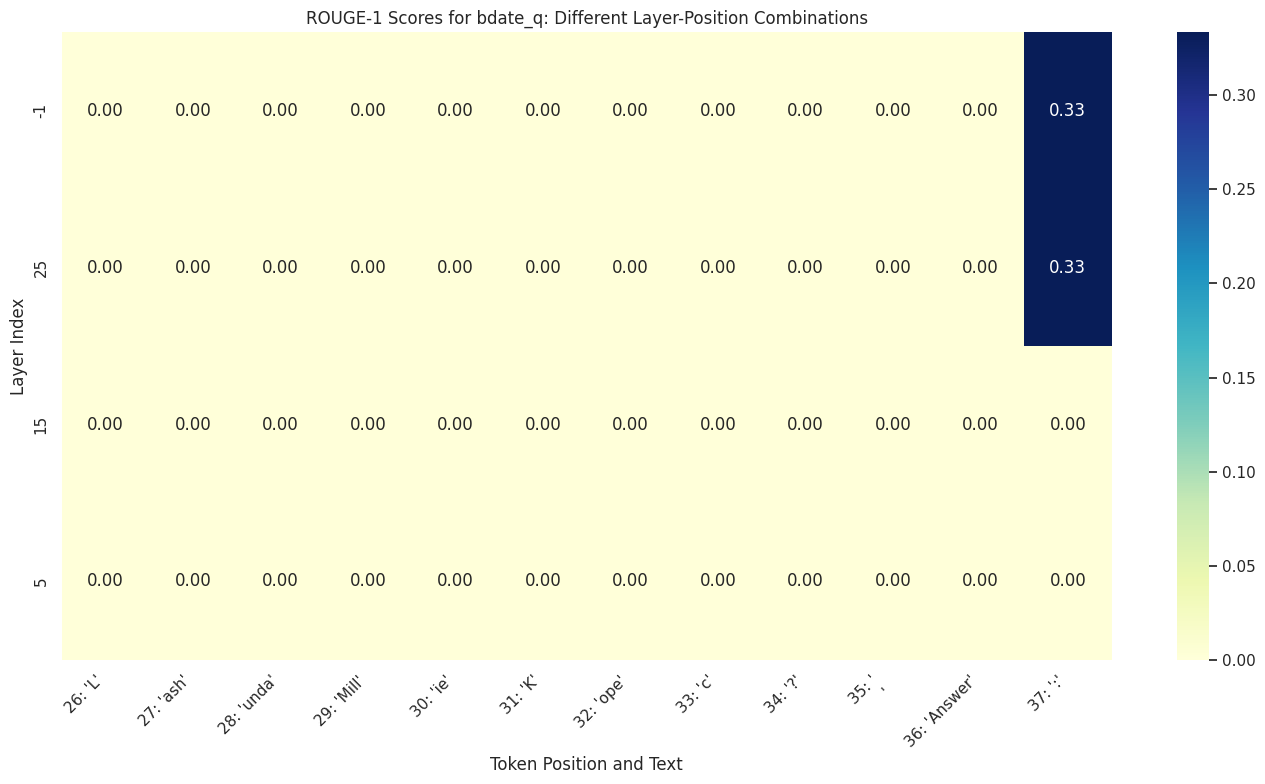

Best combination for bdate_q: Layer 25, Position 37 (37: ':'), ROUGE-1 Score: 0.3333

Processing question category: bcity_q / bcity_a
Source name 'Lashunda Millie Kopec' has token length: 10
Subject name 'Lashunda Millie Kopec' found at token positions 26 to 33
Subject tokens text: 'Lashunda Millie Kopec'


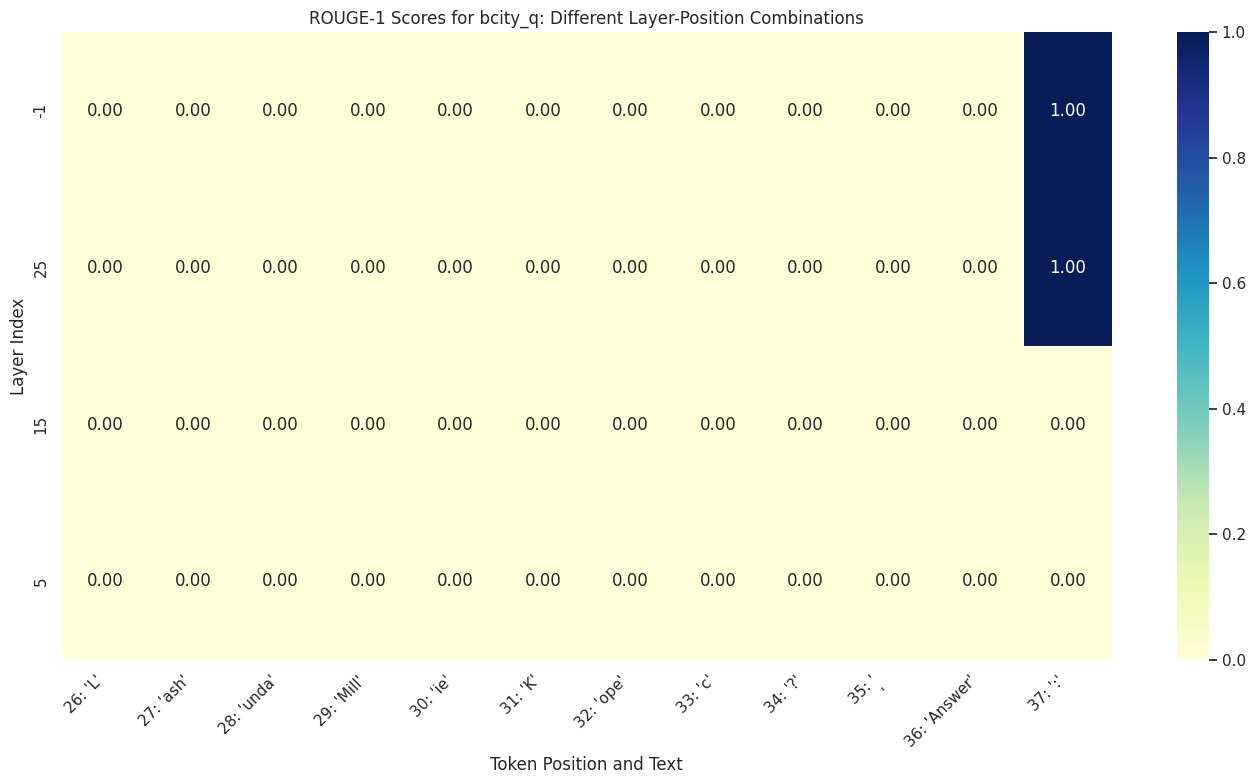

Best combination for bcity_q: Layer 25, Position 37 (37: ':'), ROUGE-1 Score: 1.0000

Processing question category: university_q / university_a
Source name 'Lashunda Millie Kopec' has token length: 10
Subject name 'Lashunda Millie Kopec' found at token positions 23 to 30
Subject tokens text: 'Lashunda Millie Kopec'


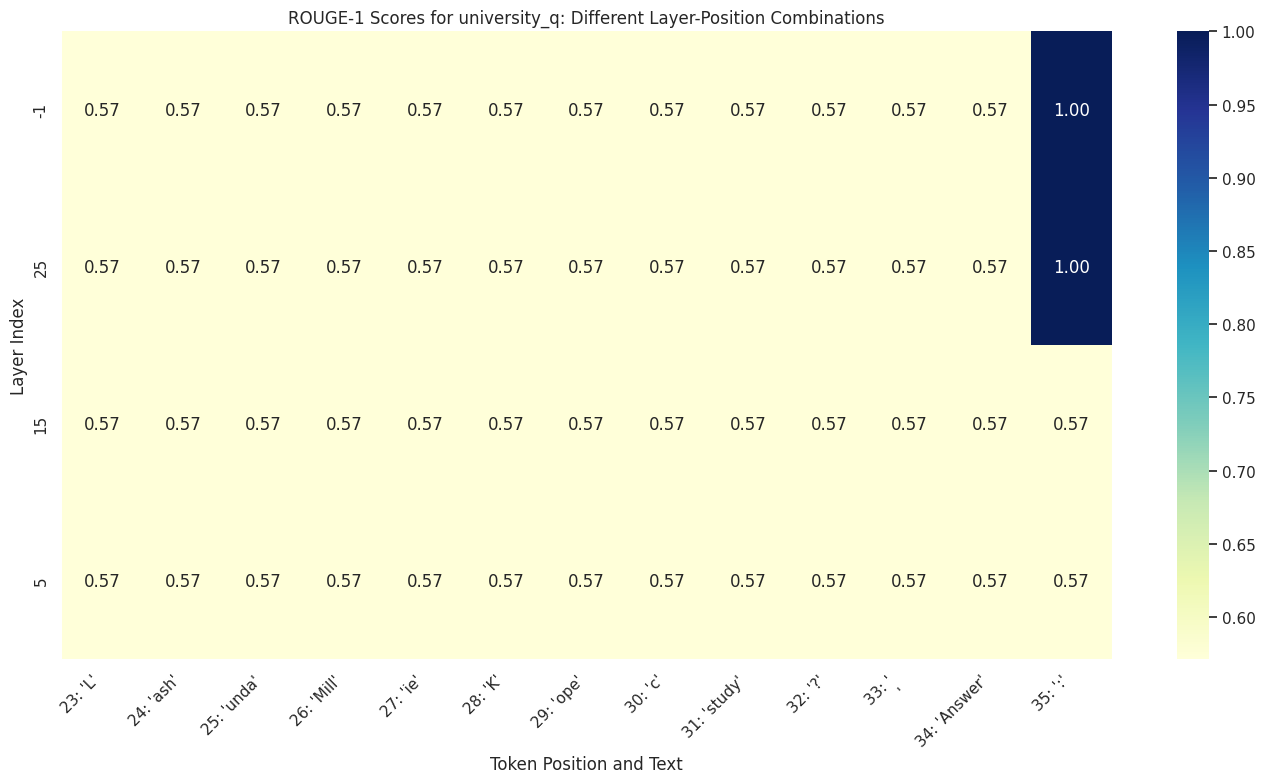

Best combination for university_q: Layer 25, Position 35 (35: ':'), ROUGE-1 Score: 1.0000

Processing question category: major_q / major_a
Source name 'Lashunda Millie Kopec' has token length: 10
Subject name 'Lashunda Millie Kopec' found at token positions 23 to 30
Subject tokens text: 'Lashunda Millie Kopec'


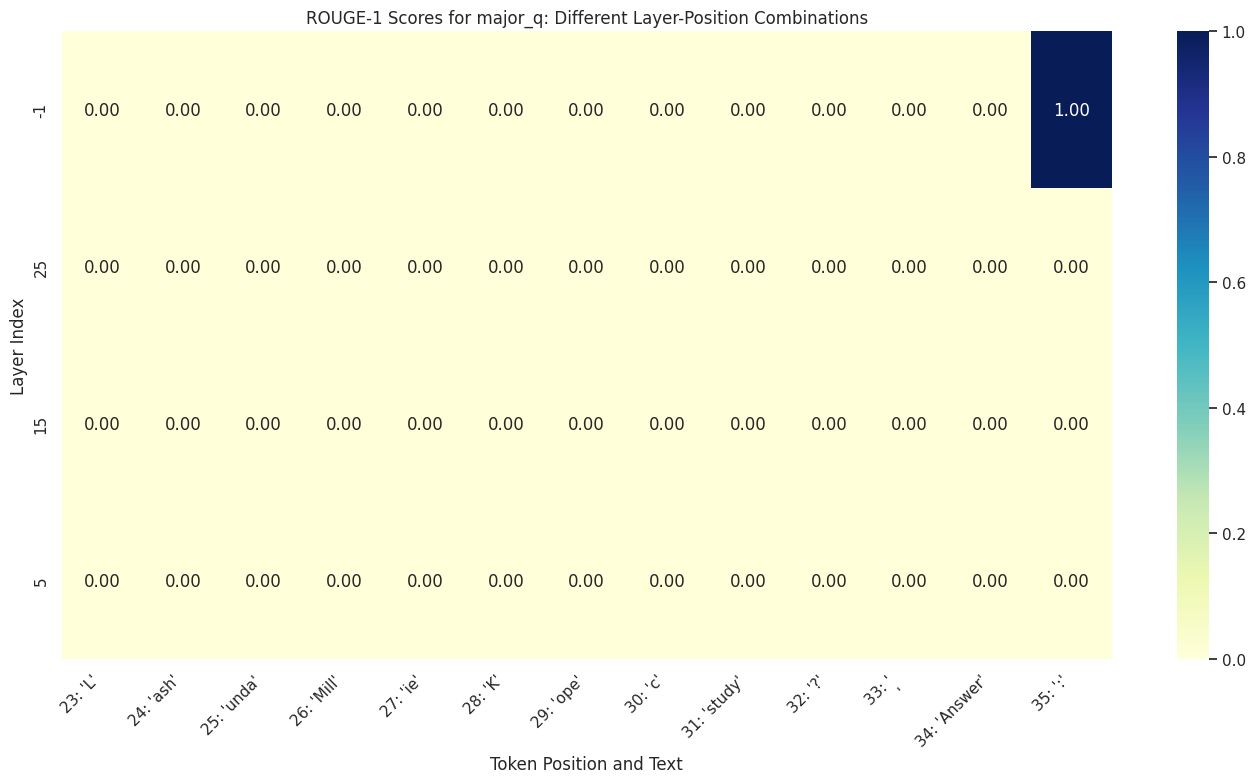

Best combination for major_q: Layer -1, Position 35 (35: ':'), ROUGE-1 Score: 1.0000

Processing question category: employer_q / employer_a
Source name 'Lashunda Millie Kopec' has token length: 10
Subject name 'Lashunda Millie Kopec' found at token positions 23 to 30
Subject tokens text: 'Lashunda Millie Kopec'


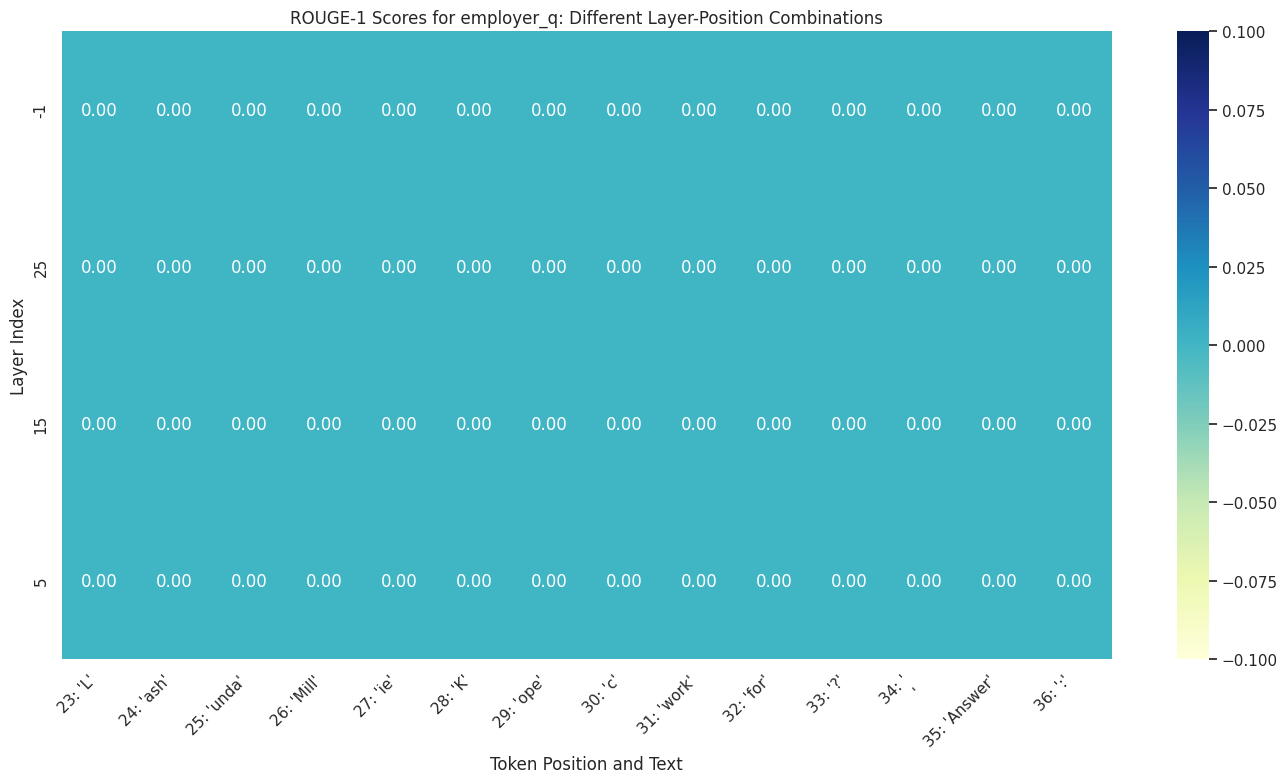

Best combination for employer_q: Layer 5, Position 23 (23: 'L'), ROUGE-1 Score: 0.0000

Processing question category: company_city_q / company_city_a
Source name 'Lashunda Millie Kopec' has token length: 10
Subject name 'Lashunda Millie Kopec' found at token positions 22 to 29
Subject tokens text: 'Lashunda Millie Kopec'


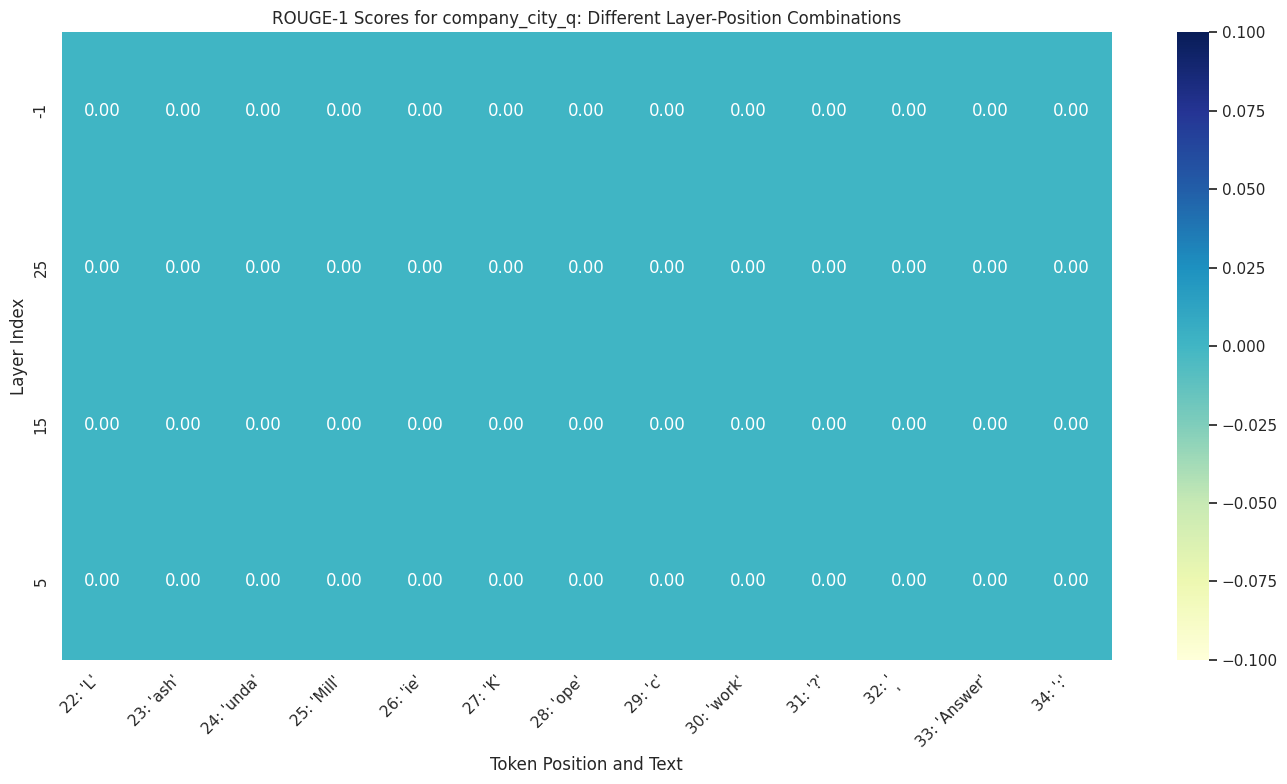

Best combination for company_city_q: Layer 5, Position 22 (22: 'L'), ROUGE-1 Score: 0.0000


In [11]:
# Step 1: Group names by encoded token length
name_to_token_length = {}
for example in train_dataset:
    name = example['name']
    tokens = mt.tokenizer.encode(" " + name)
    token_length = len(tokens)
    if token_length not in name_to_token_length:
        name_to_token_length[token_length] = []
    name_to_token_length[token_length].append(name)

print(f"Token length distribution: {[(length, len(names)) for length, names in name_to_token_length.items()]}")

# Define layers to test
layers_to_test = [5, 15, 25, -1] # np.arange(1, 40) # 39 is the last layer for Llama-2-13b
# Reverse order for plotting
layers_to_test_reversed = layers_to_test[::-1]

# Store results for each question category
all_results = {}

idx = 0
source_subject_name = train_dataset[idx]["name"]

# Loop through all question categories
for q_idx, q_key in enumerate(question_keys):
    a_key = answer_keys[q_idx]
    print(f"\n{'='*80}\nProcessing question category: {q_key} / {a_key}\n{'='*80}")
    
    # Step 2: Process source prompt
    # Get token length of current source subject
    source_name_tokens = mt.tokenizer.encode(" " + source_subject_name)
    source_name_token_length = len(source_name_tokens)
    print(f"Source name '{source_subject_name}' has token length: {source_name_token_length}")

    # Find names with same token length (excluding the source name)
    same_length_names = [n for n in name_to_token_length.get(source_name_token_length, []) 
                         if n != source_subject_name]

    if not same_length_names:
        print("No other names with the same token length found.")
        # Use original target if no matching length name is found
        patching_target_name = target_subject_name
    else:
        # Randomly select a target name with the same token length
        patching_target_name = random.choice(same_length_names)

    # Find this name in the dataset to get the corresponding prompt
    target_examples = [i for i, ex in enumerate(train_dataset) if ex['name'] == patching_target_name]
    if target_examples:
        patching_target_idx = target_examples[0]
        patching_target_prompt = format_prompt(train_dataset[patching_target_idx], q_key)
        patching_expected_answer = train_dataset[idx][a_key]
    else:
        # Fallback to original target
        source_prompt_idx = question_keys.index(q_key) * len(train_dataset) 
        patching_target_prompt = prompts[source_prompt_idx + 6]  # +6 for the target subject
        patching_expected_answer = answers[source_prompt_idx + 6]

    # Step 3 & 4: Run patching experiments for different positions and layers
    source_prompt = format_prompt(train_dataset[0], q_key)
    source_tokens = mt.tokenizer.encode(source_prompt)
    subj_first_pos, subj_last_pos = get_subject_token_position(mt, source_prompt, source_subject_name)
    # subj_first_pos = 29  # Based on the context, this seems to be a fixed position
    last_token_pos = len(source_tokens) - 1

    # Initialize results matrix for heatmap
    positions_range = list(range(subj_first_pos, last_token_pos + 1))
    rouge_scores_matrix = np.zeros((len(layers_to_test), len(positions_range)))
    
    # Decode tokens for x-axis labels
    token_labels = []
    for position in positions_range:
        token_id = source_tokens[position]
        token_text = mt.tokenizer.decode([token_id])
        token_labels.append(f"{position}: '{token_text}'")

    # Run experiments
    for layer_idx, layer in enumerate(layers_to_test):
        for pos_idx, position in enumerate(positions_range):
            result = inspect(
                mt=mt,
                prompt_source=source_prompt,
                prompt_target=patching_target_prompt,
                layer_source=layer,
                layer_target=layer,
                position_source=position,
                position_target=position,
                module="hs",
                generation_mode=True,
                max_gen_len=15
            )
            
            # Extract date from result
            extracted_result = result.split('\n')[0].strip() if '\n' in result else result.strip()
            
            # Calculate ROUGE score
            score = scorer.score(patching_expected_answer, extracted_result)
            rouge_scores_matrix[layer_idx, pos_idx] = score['rouge1'].fmeasure

    # Store results for this question category
    all_results[q_key] = {
        'rouge_scores_matrix': rouge_scores_matrix,
        'positions_range': positions_range,
        'expected_answer': patching_expected_answer,
        'token_labels': token_labels
    }
    
    # Step 5: Plot heatmap for this category
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(
        rouge_scores_matrix[::-1],  # Reverse the order of layers
        annot=True, 
        fmt=".2f", 
        cmap="YlGnBu",
        xticklabels=token_labels,
        yticklabels=[str(l) for l in layers_to_test_reversed]  # Reversed layers
    )
    plt.xlabel('Token Position and Text')
    plt.ylabel('Layer Index')
    plt.title(f'ROUGE-1 Scores for {q_key}: Different Layer-Position Combinations')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print best combinations
    flat_idx = np.argmax(rouge_scores_matrix)
    best_layer_idx = flat_idx // len(positions_range)
    best_pos_idx = flat_idx % len(positions_range)
    best_layer = layers_to_test[best_layer_idx]
    best_position = positions_range[best_pos_idx]
    best_score = rouge_scores_matrix[best_layer_idx, best_pos_idx]
    best_token = token_labels[best_pos_idx]

    print(f"Best combination for {q_key}: Layer {best_layer}, Position {best_position} ({best_token}), ROUGE-1 Score: {best_score:.4f}")